# CAE Classification for 3 Painters #

In [24]:
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D
from tensorflow.keras import layers, losses
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split


from utils.get_model import *
from utils.image_formatting import *
from utils.evaluate import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# artists = ['claude-monet', 'pablo-picasso', 'william-turner']

X, y = preprocess_images2(artists=list(PAINTER_DICT.keys()), n_imgs=1000, dropout_rate=None)
X_train, X_val, _, _ = train_test_split(X, y, test_size=0.05)   

print(X_train.shape)
print(X_val.shape)

(5379, 256, 256, 3)
(284, 256, 256, 3)


In [26]:
# autoencoder = build_autoencoder(optimizer='adam', loss='tf.keras.losses.KLDivergence()',
#               metrics=tf.keras.metrics.KLDivergence())
autoencoder = build_autoencoder(optimizer='adam', loss='mse', metrics=['mse'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 256, 256, 10)      760       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 128, 128, 10)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 128, 128, 20)      5020      
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 64, 64, 20)        0         
_________________________________________________________________
UpSample_1 (UpSampling2D)    (None, 128, 128, 20)      0         
_________________________________________________________________
Conv2DTrans_1 (Conv2DTranspo (None, 128, 128, 20)      10020     
_________________________________________________________________
UpSample_2 (UpSampling2D)    (None, 256, 256, 20)     

In [27]:
autoencoder_training_history = autoencoder.fit(x=X_train, y=X_train, batch_size=32, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
169/169 [==============================] - 401s 2s/step - loss: 3677.0396 - mse: 3677.0396 - val_loss: 1135.5961 - val_mse: 1135.5961
Epoch 2/10
169/169 [==============================] - 394s 2s/step - loss: 441.8925 - mse: 441.8925 - val_loss: 299.9974 - val_mse: 299.9974
Epoch 3/10
169/169 [==============================] - 395s 2s/step - loss: 292.6394 - mse: 292.6394 - val_loss: 290.9146 - val_mse: 290.9146
Epoch 4/10
169/169 [==============================] - 397s 2s/step - loss: 263.0015 - mse: 263.0015 - val_loss: 315.7647 - val_mse: 315.7647
Epoch 5/10
169/169 [==============================] - 398s 2s/step - loss: 238.1808 - mse: 238.1808 - val_loss: 220.8040 - val_mse: 220.8040
Epoch 6/10
169/169 [==============================] - 398s 2s/step - loss: 227.0473 - mse: 227.0473 - val_loss: 208.0492 - val_mse: 208.0492
Epoch 7/10
169/169 [==============================] - 403s 2s/step - loss: 212.4342 - mse: 212.4342 - val_loss: 240.4546 - val_mse: 240.4546
Epoch 8/1

INFO:tensorflow:Assets written to: models/autoencoder_3PainterCAE_2021-04-23-16-15/assets


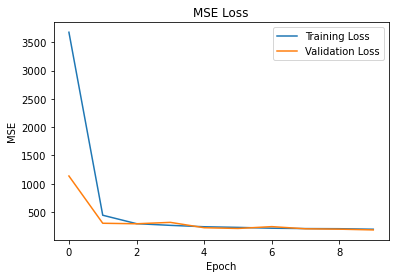

In [28]:
# save autoencoder 
timestamp = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
autoencoder_path = 'models/autoencoder_3PainterCAE_{}'.format(timestamp)
autoencoder.save(autoencoder_path)

plt.plot(autoencoder_training_history.history['loss'], label='Training Loss')
plt.plot(autoencoder_training_history.history['val_loss'], label='Validation Loss')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')
# plt.savefig('figures/autoencoder_3PainterCAE_loss_{}'.format(timestamp))
plt.savefig('figures/autoencoder_all_data')

plt.show()


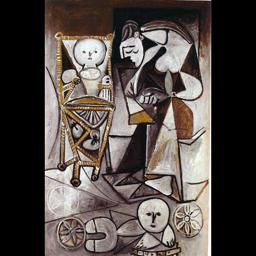

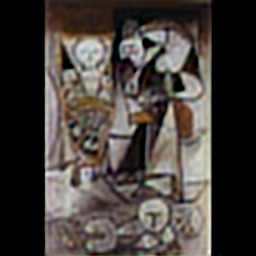

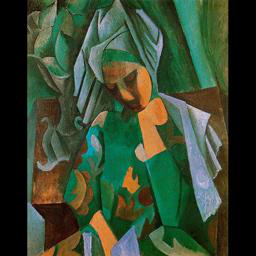

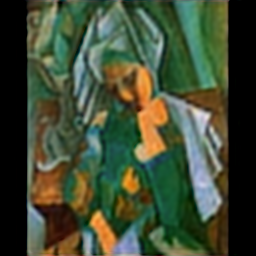

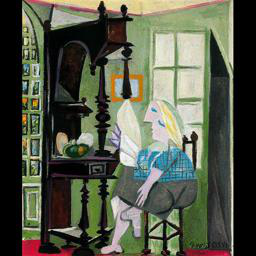

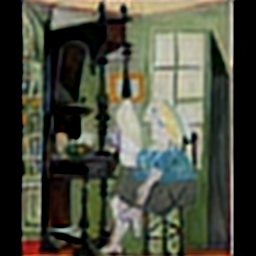

In [29]:
# visually inspect output of autoencoder

for i in range(3):
    compare_output(autoencoder, X[i])


In [18]:
# reshuffle, add dropout
artists = ['claude-monet', 'pablo-picasso', 'vincent-van-gogh']

X, y = preprocess_images2(artists=artists, n_imgs=1000, dropout_rate=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2700, 256, 256, 3) (2700,)
(300, 256, 256, 3) (300,)


In [19]:
output_size = max(y) + 1


def build_cae(autoencoder, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-6].output, name='encoder')
    for encoding_layer in encoder.layers:     # freeze encoding weights
        encoding_layer.trainable = False
    input_shape = (encoder.output.shape[1], encoder.output.shape[2], encoder.output.shape[3])
    classifier = Sequential(name='classifier')
    classifier.add(tf.keras.layers.Input(shape=input_shape, name='dense_input'))
    classifier.add(Flatten(name='flatten'))
    classifier.add(Dense(40, activation='relu', name='dense_1'))
    classifier.add(Dense(20, activation='relu', name='dense_2'))
    classifier.add(Dense(output_size, activation='softmax', name='softmax'))
    cae = Model(inputs=encoder.inputs, outputs=classifier(encoder.output), name='cae')
    cae.summary()
    classifier.summary()
    cae.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return cae
    

In [20]:
cae = build_cae(autoencoder)

Model: "cae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 256, 256, 10)      760       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 128, 128, 10)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 128, 128, 20)      5020      
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 64, 64, 20)        0         
_________________________________________________________________
classifier (Sequential)      (None, 3)                 3277723   
Total params: 3,283,503
Trainable params: 3,277,723
Non-trainable params: 5,780
_________________________________________________

In [21]:
cae_training_history = cae.fit(x=X_train, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
85/85 [==============================] - 10s 120ms/step - loss: 498.0708 - accuracy: 0.5130 - val_loss: 131.5458 - val_accuracy: 0.5267
Epoch 2/15
85/85 [==============================] - 10s 116ms/step - loss: 142.8122 - accuracy: 0.5611 - val_loss: 124.4976 - val_accuracy: 0.5767
Epoch 3/15
85/85 [==============================] - 10s 120ms/step - loss: 84.2864 - accuracy: 0.6226 - val_loss: 66.7737 - val_accuracy: 0.6400
Epoch 4/15
85/85 [==============================] - 11s 127ms/step - loss: 65.1655 - accuracy: 0.6585 - val_loss: 92.1039 - val_accuracy: 0.6267
Epoch 5/15
85/85 [==============================] - 11s 131ms/step - loss: 83.5356 - accuracy: 0.6411 - val_loss: 150.3615 - val_accuracy: 0.5700
Epoch 6/15
85/85 [==============================] - 11s 132ms/step - loss: 44.4560 - accuracy: 0.7211 - val_loss: 110.5155 - val_accuracy: 0.4867
Epoch 7/15
85/85 [==============================] - 11s 133ms/step - loss: 39.4757 - accuracy: 0.7252 - val_loss: 66.3025 - 

INFO:tensorflow:Assets written to: models/cae_3PainterCAE_2021-04-23-10-29/assets


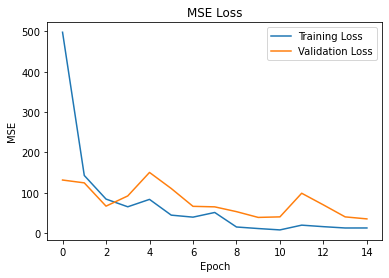

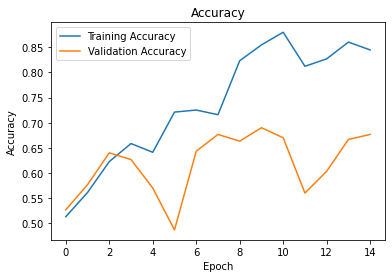

In [22]:
# save cae
timestamp = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
cae_path = 'models/cae_3PainterCAE_{}'.format(timestamp)
cae.save(cae_path)

plt.plot(cae_training_history.history['loss'], label='Training Loss')
plt.plot(cae_training_history.history['val_loss'], label='Validation Loss')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.savefig('figures/cae_3PainterCAE_loss_{}'.format(timestamp))
plt.show()

plt.plot(cae_training_history.history['accuracy'], label='Training Accuracy')
plt.plot(cae_training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig('figures/cae_3PainterCAE_accuracy_{}'.format(timestamp))
plt.show()


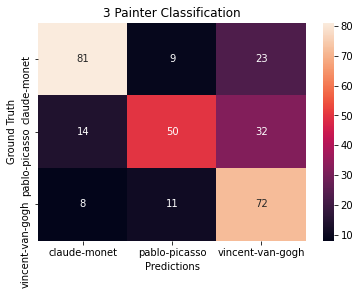

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       113
           1       0.71      0.52      0.60        96
           2       0.57      0.79      0.66        91

    accuracy                           0.68       300
   macro avg       0.69      0.68      0.67       300
weighted avg       0.70      0.68      0.68       300



In [23]:
predictions = tf.argmax(cae.predict(X_val), axis=1)         # generate predictions

report = make_confusion_matrix(cae, predictions, y_val, "3 Painter Classification", timestamp, artists, 'cae_3PainterCAE')

print(report)

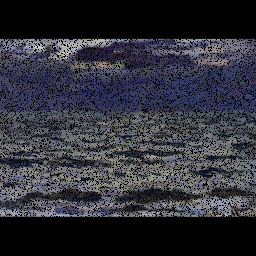

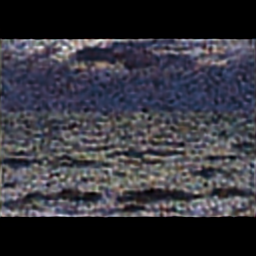

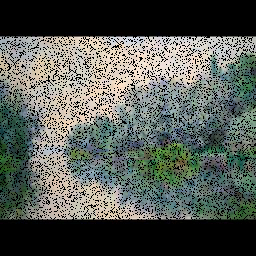

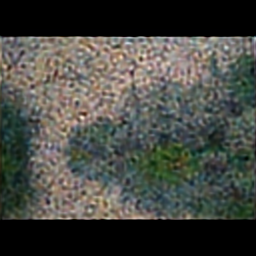

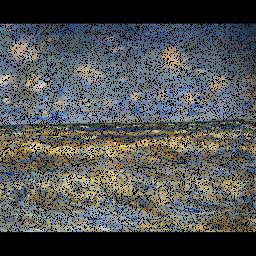

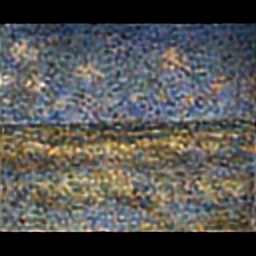

In [14]:
# visually inspect output of autoencoder after cae training
for i in range(3):
    compare_output(autoencoder, X[i])